<a href="https://colab.research.google.com/github/treiro/segmentation-models-demo/blob/main/Unet_binary_segmentation_(camvid).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Reqirements
- keras >= 2.2.0 or tensorflow >= 1.13
- segmenation-models==1.0.*
- albumentations==0.3.0

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cp  gdrive/MyDrive/COLAB/Unet/Unet-segmentation_models/CamVid.zip  .

In [3]:
! unzip CamVid.zip

Archive:  CamVid.zip
   creating: CamVid/
  inflating: CamVid/test.txt         
   creating: CamVid/test/
  inflating: CamVid/test/0001TP_008550.png  
  inflating: CamVid/test/0001TP_008580.png  
  inflating: CamVid/test/0001TP_008610.png  
  inflating: CamVid/test/0001TP_008640.png  
  inflating: CamVid/test/0001TP_008670.png  
  inflating: CamVid/test/0001TP_008700.png  
  inflating: CamVid/test/0001TP_008730.png  
  inflating: CamVid/test/0001TP_008760.png  
  inflating: CamVid/test/0001TP_008790.png  
  inflating: CamVid/test/0001TP_008820.png  
  inflating: CamVid/test/0001TP_008850.png  
  inflating: CamVid/test/0001TP_008880.png  
  inflating: CamVid/test/0001TP_008910.png  
  inflating: CamVid/test/0001TP_008940.png  
  inflating: CamVid/test/0001TP_008970.png  
  inflating: CamVid/test/0001TP_009000.png  
  inflating: CamVid/test/0001TP_009030.png  
  inflating: CamVid/test/0001TP_009060.png  
  inflating: CamVid/test/0001TP_009090.png  
  inflating: CamVid/test/0001TP_009120.

In [ ]:
%ls

CamVid/  CamVid.zip  gdrive/  sample_data/


In [4]:
# Install required libs
!pip uninstall albumentations
### please update Albumentations to version>=0.3.0 for `Lambda` transform support
!pip install -U albumentations==1.0.3 --user
!pip install -U --pre segmentation-models --user


Found existing installation: albumentations 0.1.12
Uninstalling albumentations-0.1.12:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/albumentations-0.1.12.dist-info/*
    /usr/local/lib/python3.7/dist-packages/albumentations/*
Proceed (y/n)? y
  Successfully uninstalled albumentations-0.1.12

     |████████████████████████████████| 98 kB 5.4 MB/s 
     |████████████████████████████████| 37.1 MB 39 kB/s 
     |████████████████████████████████| 50 kB 7.0 MB/s 


In [ ]:
import keras
keras.__version__

'2.5.0'

#Restart runtime for update new album version = 1.0.3

In [ ]:
import os
os.kill(os.getpid(), 9)

In [1]:
import albumentations
albumentations.__version__

'1.0.3'

# Loading dataset

# Dataloader and utility functions 

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence


In [3]:
DATA_DIR = 'CamVid/'

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Dataloader and utility functions 

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)

        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        # print(mask)
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        # print(self.class_values)
        # print(masks)
        mask = np.stack(masks, axis=-1).astype('float')
        # print(mask)
        # print(mask.shape)
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            # print(background.shape)
            mask = np.concatenate((mask, background), axis=-1)
        # print(image.shape)
        # print(mask.shape)
        # print('-----------------------')
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            # print(sample)

            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        # data = []
        X =[]
        y = []
        # X= np.empty((self.batch_size, 320, 320, 3))
        # y = np.empty((self.batch_size, 320, 320, 1), dtype=int)
        for j in range(start, stop):
            xj, yj = self.dataset[j]
            # data.append((xj, yj))
            X.append(xj)
            y.append(yj)
            # X[i,] = xj
            # y[i,] = yj
        # return X, y
        # a = np.array(X)
        # print(a.shape)
        return np.array(X), np.array(y)
        #zip(*data) = zip(data0,.., data7) = zip((x0,y0), .., (x7, y7)) = [(x0..x7), (y0..y7)]
        # transpose list of lists
        # batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        # return batch
        #Convert array to tuple (x, y)
        # return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

CamVid/trainannot


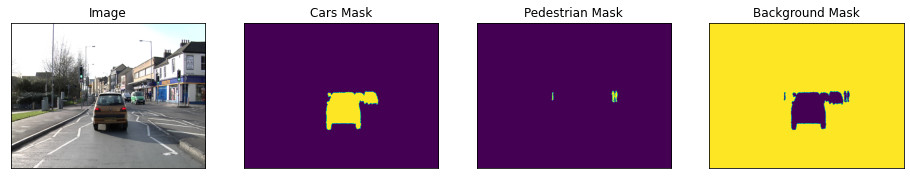

In [5]:
# Lets look at data we have
print(y_train_dir)
dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'pedestrian'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    pedestrian_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [6]:
import albumentations as A

In [7]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(384, 480)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/root/.local/lib/python3.7/site-package

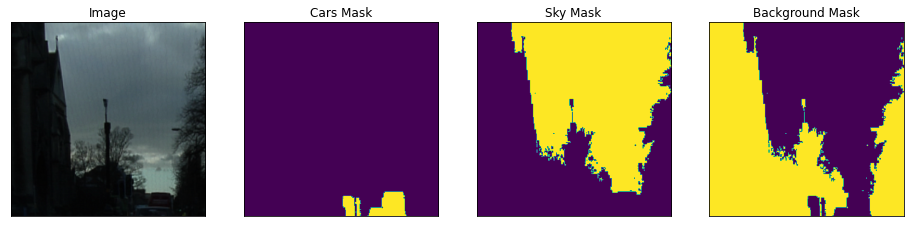

In [8]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'sky'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    cars_mask=mask[..., 0].squeeze(),
    sky_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)

# Segmentation model training

In [9]:
import segmentation_models as sm

sm.set_framework('tf.keras')

sm.framework()

# segmentation_models could also use `tf.keras` if you do not have Keras installed
# or you could switch to other framework using `sm.set_framework('tf.keras')`

Segmentation Models: using `keras` framework.


'tf.keras'

In [10]:
BACKBONE = 'resnet34'
BATCH_SIZE = 8
CLASSES = ['car']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)

In [11]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

85524480/85521592 [==============================] - 1s 0us/step


In [12]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

In [13]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)
print(len(train_dataset))
print(len(valid_dataloader))
# # check shapes for errors
# assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
# assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)
# print(train_dataloader[0][0].shape)
# print(len(train_dataloader[0]))
# train_dataloader[0]
# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

367
101


/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/root/.local/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/root/.local/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/root/.local/lib/python3.7/site-package

In [14]:
# train model
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
45/45 [==============================] - 52s 294ms/step - loss: 0.9204 - iou_score: 0.2115 - f1-score: 0.3296 - val_loss: 1.2555 - val_iou_score: 0.0212 - val_f1-score: 0.0402
Epoch 2/40
45/45 [==============================] - 12s 255ms/step - loss: 0.7644 - iou_score: 0.4785 - f1-score: 0.6322 - val_loss: 0.9922 - val_iou_score: 0.1859 - val_f1-score: 0.2855
Epoch 3/40
45/45 [==============================] - 12s 254ms/step - loss: 0.6843 - iou_score: 0.5991 - f1-score: 0.7375 - val_loss: 0.9671 - val_iou_score: 0.2712 - val_f1-score: 0.3996
Epoch 4/40
45/45 [==============================] - 12s 256ms/step - loss: 0.6005 - iou_score: 0.6541 - f1-score: 0.7825 - val_loss: 0.8723 - val_iou_score: 0.5643 - val_f1-score: 0.6688
Epoch 5/40
45/45 [==============================] - 12s 263ms/step - loss: 0.5476 - iou_score: 0.6964 - f1-score: 0.8119 - val_loss: 0.8150 - val_iou_score: 0.6238 - val_f1-score: 0.7313
Epoch 6/40
45/45 [==============================] - 12s 267ms/ste

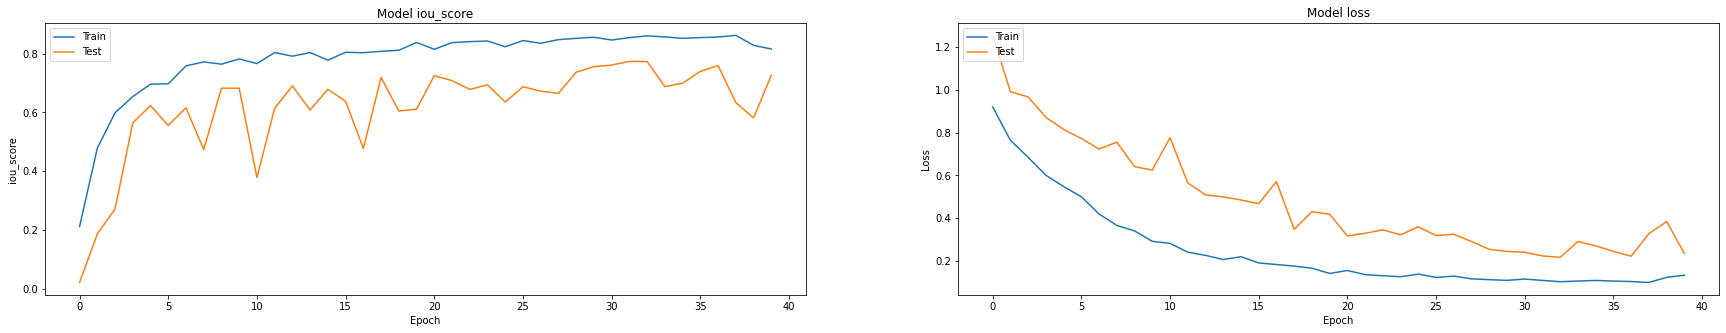

In [15]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model Evaluation

In [16]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [17]:
# load best weights
model.load_weights('best_model.h5') 

In [18]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss: 0.30076
mean iou_score: 0.76209
mean f1-score: 0.83933


# Visualization of results on test dataset

(384, 480, 3)
(384, 480, 1)
-----------
(1, 384, 480, 3)
(1, 384, 480, 1)


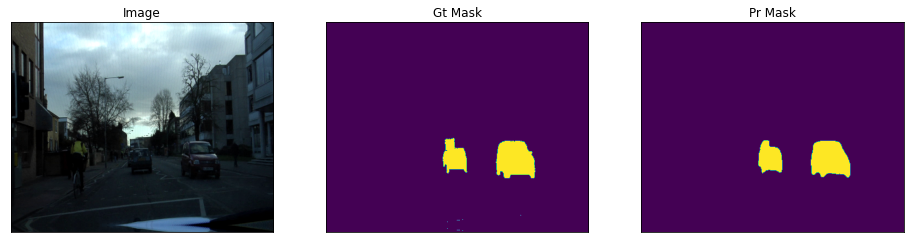

(384, 480, 3)
(384, 480, 1)
-----------
(1, 384, 480, 3)
(1, 384, 480, 1)


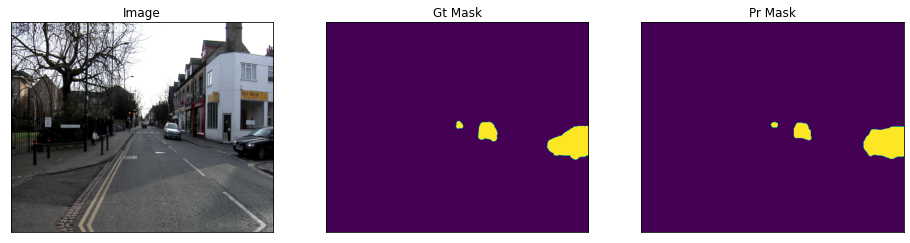

(384, 480, 3)
(384, 480, 1)
-----------
(1, 384, 480, 3)
(1, 384, 480, 1)


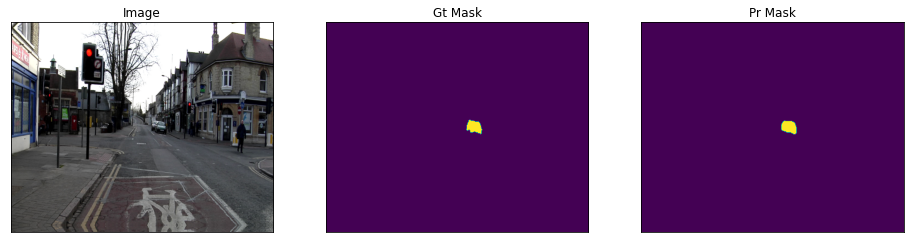

(384, 480, 3)
(384, 480, 1)
-----------
(1, 384, 480, 3)
(1, 384, 480, 1)


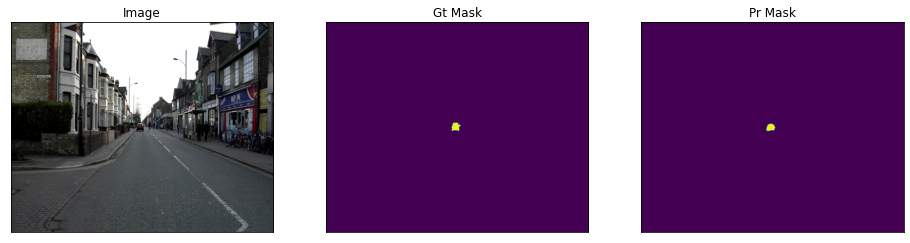

(384, 480, 3)
(384, 480, 1)
-----------
(1, 384, 480, 3)
(1, 384, 480, 1)


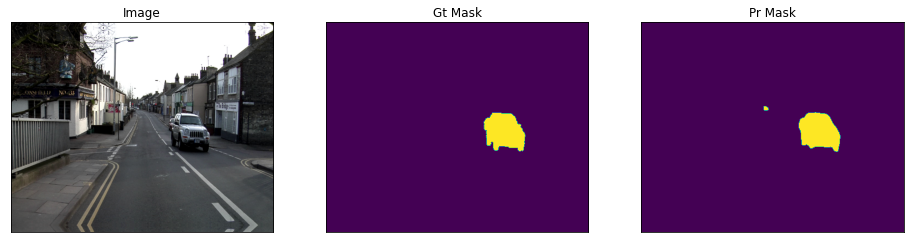

In [19]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    print(image.shape)
    print(gt_mask.shape)
    print('-----------')
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    print(image.shape)
    print(pr_mask.shape)
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )